# Startup

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 29.9 MB/s 
     |████████████████████████████████| 749 kB 54.3 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

from nltk.util import pad_sequence
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving valid_data.csv to valid_data.csv


In [ ]:
load_paths = ['../../data/train_data.csv', '../../data/valid_data.csv', '../../data/test_data.csv']
load_paths = ['./train_data.csv', './valid_data.csv', './test_data.csv']

train_data = pd.read_csv(load_paths[0])
valid_data = pd.read_csv(load_paths[1])
test_data = pd.read_csv(load_paths[2])

In [ ]:
def filter_unwanted_rows(data):
    y = data['Label'].tolist()
    to_drop = [i for i in range(len(y)) if y[i] > 3]
    new_data = data.drop(labels=to_drop, axis=0)
    return np.asarray(new_data['Source']), np.asarray(new_data['Label'])

In [ ]:
X_train, y_train = filter_unwanted_rows(train_data)
X_test, y_test = filter_unwanted_rows(test_data)
X_valid, y_valid = filter_unwanted_rows(valid_data)

# LM Training

In [ ]:
n = 3

In [ ]:
tokenized_data = []

for text in X_train:
    current_text_details = [word_tokenize(sent.lower()) for sent in sent_tokenize(text)]
    tokenized_data += current_text_details

train_data, padded_sents = padded_everygram_pipeline(n, tokenized_data)
model = MLE(n)
model.fit(train_data, padded_sents)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Feature Extraction

In [ ]:
EPSILON = 1e-9
INF = 1e9
K = 12
# K frequent and K rarest n-gram probabilities of a sentence are considered as features

In [ ]:
def get_all_ngram_probabilities(given_text):
    global model, INF, n
    text = given_text.lower()
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return [], INF
    all_ngram_probabilities, all_perplexities = [], []
    for sent in sentences:
        words = word_tokenize(sent)
        curr_ngrams = list(ngrams(words, n=n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
        all_ngram_probabilities.append([max(EPSILON, model.score(ngram[-1], ngram[:-1])) for ngram in curr_ngrams])
        perplexity = model.perplexity(curr_ngrams)
        if perplexity == 'inf':
            perplexity = INF
        all_perplexities.append(perplexity)
    return all_ngram_probabilities, sum(all_perplexities) / len(all_perplexities)

In [ ]:
def get_feature_vector(text):
    global K
    all_ngram_probabilities, perplexity = get_all_ngram_probabilities(text) 
    all_ngram_probabilities = sorted(sum(all_ngram_probabilities, []))
    if len(all_ngram_probabilities) == 0:
        return [0 for _ in range(2*K)] + [INF]
    frequent_k, rarest_k = all_ngram_probabilities[-K:], all_ngram_probabilities[:K]
    if len(frequent_k) < K:
        median = frequent_k[len(frequent_k) // 2]
        for _ in range(K - len(frequent_k)):
            frequent_k.append(median)
        frequent_k = sorted(frequent_k)
    if len(rarest_k) < K:
        median = rarest_k[len(rarest_k) // 2]
        for _ in range(K - len(rarest_k)):
            rarest_k.append(median)
        rarest_k = sorted(rarest_k)
    return frequent_k + rarest_k + [perplexity]

In [ ]:
from sklearn.linear_model import LogisticRegression

# Training on train set, testing on both validation and test sets - 70:30
train_features, train_labels, test_features, test_labels = [], [], [], []
scores, improved_scores = [], []

for i in range(len(X_train)):
    train_features.append(get_feature_vector(X_train[i]))
    train_labels.append(y_train[i])

for i in range(len(X_test)):
    test_features.append(get_feature_vector(X_test[i]))
    test_labels.append(y_test[i])

for i in range(len(X_valid)):
    test_features.append(get_feature_vector(X_valid[i]))
    test_labels.append(y_valid[i])

# Training

In [ ]:
# Different techniques for tackling class imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE

def balance_data(x, y, _type=0):
    if _type == 1:
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(x, y)
    elif _type == 2:
        smote = SMOTE()
        return smote.fit_resample(x, y)
    return x, y

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score, classification_report
import matplotlib.pyplot as plt
import json

statements = {0: "Without oversampling", 1: "With random oversampling", 2: "With SMOTE"}

def get_metrics(b, ytrue, ypred, file_name):
    print('\n\n')
    print(statements[b] + '\n')
    print(classification_report(ytrue, ypred))
    ret = classification_report(ytrue, ypred, output_dict=True)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(f"{file_name}_{b}_{n}_{K}_conf.png",dpi=300)
    plt.show()
    print('\n\n')
    with open(f"{file_name}_{b}_{n}_{K}_stats.json", "w") as f:
        json.dump(ret, f, indent=4)


For training set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00      1942
           3       0.87      1.00      0.93     14021

    accuracy                           0.87     16028
   macro avg       0.29      0.33      0.31     16028
weighted avg       0.77      0.87      0.82     16028



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

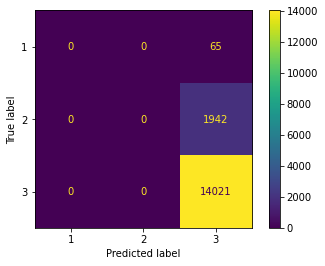





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       871
           3       0.87      1.00      0.93      6022

    accuracy                           0.87      6914
   macro avg       0.29      0.33      0.31      6914
weighted avg       0.76      0.87      0.81      6914



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

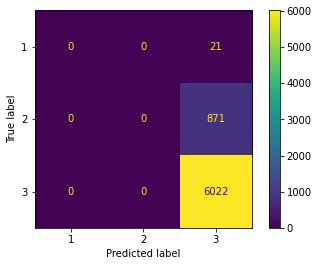




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For training set




With random oversampling



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14021
           2       0.00      0.00      0.00     14021
           3       0.33      1.00      0.50     14021

    accuracy                           0.33     42063
   macro avg       0.11      0.33      0.17     42063
weighted avg       0.11      0.33      0.17     42063



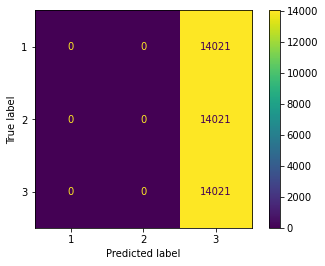





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       871
           3       0.87      1.00      0.93      6022

    accuracy                           0.87      6914
   macro avg       0.29      0.33      0.31      6914
weighted avg       0.76      0.87      0.81      6914



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

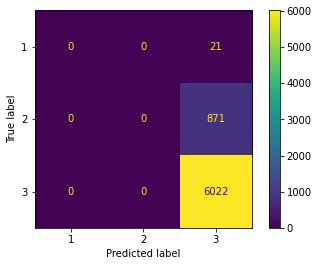




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For training set




With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14021
           2       0.33      1.00      0.50     14021
           3       0.00      0.00      0.00     14021

    accuracy                           0.33     42063
   macro avg       0.11      0.33      0.17     42063
weighted avg       0.11      0.33      0.17     42063



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

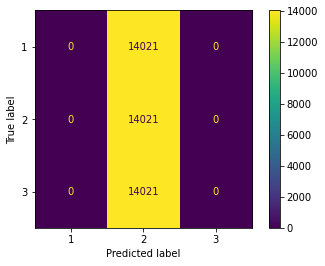





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.13      1.00      0.22       871
           3       0.00      0.00      0.00      6022

    accuracy                           0.13      6914
   macro avg       0.04      0.33      0.07      6914
weighted avg       0.02      0.13      0.03      6914



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

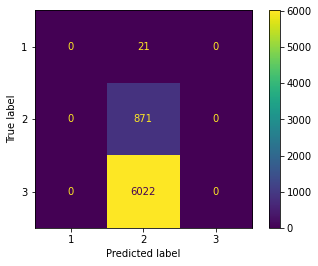




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        if str(train_f[i][-1]) == 'inf':
            train_f[i][-1] = INF
    for i in range(len(test_features)):
        if str(test_features[i][-1]) == 'inf':
            test_features[i][-1] = INF

    lr_model = LogisticRegression(random_state=123).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = lr_model.predict(train_f)
    get_metrics(t, train_l, train_pred, "Baseline")
    print("\nFor test set\n")
    test_pred = lr_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, "Baseline")
    print('-'*210)

# Final Results

In [ ]:
import json

def getMacroScores(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data["accuracy"], data["macro avg"]["precision"], data["macro avg"]["recall"], data["macro avg"]["f1-score"]

In [ ]:
lt = [0, 1, 2]
ln = [3, 4]
lK = [12, 16]

data = {"type": [], "n": [], "K": [], "accuracy": [], "precision": [], "recall": [], "f1-score": []}

for _t in lt:
    for _n in ln:
        for _K in lK:
            path = f"./Baseline_{_t}_{_n}_{_K}_stats.json"
            result = getMacroScores(path)
            data["type"].append(_t)
            data["n"].append(_n)
            data["K"].append(_K)
            data["accuracy"].append(result[0])
            data["precision"].append(result[1])
            data["recall"].append(result[2])
            data["f1-score"].append(result[3])

In [ ]:
df = pd.DataFrame(data)
df

,type,n,K,accuracy,precision,recall,f1-score
0,0,3,12,0.870986,0.290329,0.333333,0.310348
1,0,3,16,0.870986,0.290329,0.333333,0.310348
2,0,4,12,0.870986,0.290329,0.333333,0.310348
3,0,4,16,0.870986,0.290329,0.333333,0.310348
4,1,3,12,0.870986,0.290329,0.333333,0.310348
5,1,3,16,0.870986,0.290329,0.333333,0.310348
6,1,4,12,0.870986,0.290329,0.333333,0.310348
7,1,4,16,0.870986,0.290329,0.333333,0.310348
8,2,3,12,0.125976,0.041992,0.333333,0.074588
9,2,3,16,0.125976,0.041992,0.333333,0.074588


In [ ]:
tmpstate = ["None", "Random Over", "SMOTE"]
for i in range(len(data["type"])):
    print("", tmpstate[data["type"][i]], data["n"][i], data["K"][i], round(data["accuracy"][i], 3), round(data["precision"][i], 3), round(data["recall"][i], 3), round(data["f1-score"][i], 3), sep=" & ", end=" \\\\\n")

 & None & 3 & 12 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & None & 3 & 16 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & None & 4 & 12 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & None & 4 & 16 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & Random Over & 3 & 12 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & Random Over & 3 & 16 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & Random Over & 4 & 12 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & Random Over & 4 & 16 & 0.871 & 0.29 & 0.333 & 0.31 \\
 & SMOTE & 3 & 12 & 0.126 & 0.042 & 0.333 & 0.075 \\
 & SMOTE & 3 & 16 & 0.126 & 0.042 & 0.333 & 0.075 \\
 & SMOTE & 4 & 12 & 0.126 & 0.042 & 0.333 & 0.075 \\
 & SMOTE & 4 & 16 & 0.126 & 0.042 & 0.333 & 0.075 \\
